# [[데이콘] 영화 관객수 예측 모델 개발](https://dacon.io/competitions/open/235536/overview/description)

- [코드 공유](https://dacon.io/competitions/open/235536/codeshare/3713?page=1&dtype=recent)에 올라온 예측 모델 개발 코드 참조 
- [동영상](https://dacon.io/competitions/open/235536/talkboard/401139?page=1&dtype=recent)

In [1]:
# !pip install lightgbm

### step1. 필요한 패키지 및 데이터 로드

In [2]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
import multiprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('pydata/movies_train.csv')
test = pd.read_csv('pydata/movies_test.csv')
submission = pd.read_csv('pydata/submission.csv')

### step2. EDA 및 전처리

In [4]:
# train 데이터 기본 정보 확인
print(train.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB
None
(600, 12)


In [5]:
# train 데이터 셋 결측치 확인
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [6]:
# dir_prev_bfnum 컬럼 결측치 대체
train.fillna(value=0, inplace=True)
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [7]:
# 수치형 변수의 기초통계량 확인
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [8]:
# test 데이터 셋에서도 결측치가 있는지 확인
# isna()와 isnull()은 같은 함수이다.
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [9]:
# test 데이터 셋의 dir_prev_bfnum 컬럼 결측치 대체
test['dir_prev_bfnum'].fillna(value=0, inplace=True)
test.isnull().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

### step3. EDA

#### **관람객 수가 가장 많은 10개 영화 목록**

In [10]:
train.sort_values(by='box_off_num', ascending=False).head(10)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,0.000000e+00,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,0.000000e+00,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,0.000000e+00,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


#### **영화 장르별 평균 관람객 수**

In [11]:
# 장르별로 내림차순
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values(by='genre', ascending=False)

,box_off_num
genre,
코미디,1.193914e+06
액션,2.203974e+06
애니메이션,1.819267e+05
서스펜스,8.261100e+04
미스터리,5.275482e+05
뮤지컬,6.627000e+03
멜로/로맨스,4.259680e+05
드라마,6.256898e+05
다큐멘터리,6.717226e+04


#### **변수들의 분포 파악(히스토그램)**

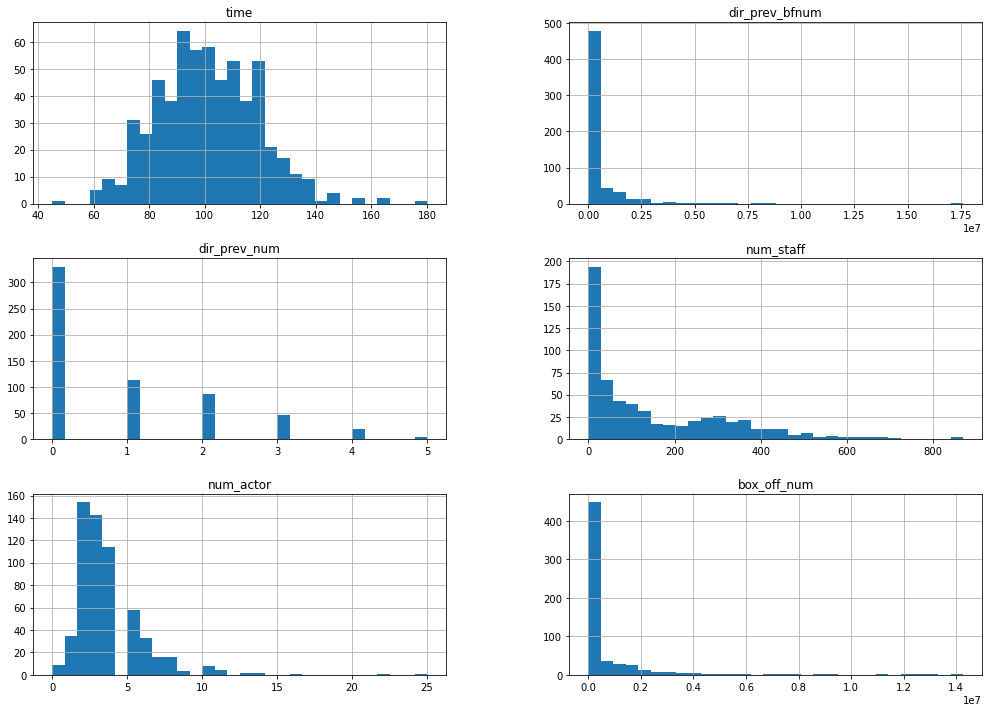

In [12]:
train.hist(bins=30, figsize = (17, 12))
plt.show()

#### **변수간 상관관계 파악(+ 히트맵)**

In [13]:
#상관분석은 숫자로 계산할 수 있으므로 데이터에서 숫자로 이루어진 컬럼만을 뽑는다
train_number = train.select_dtypes(np.number)

In [14]:
corr = train_number.corr()

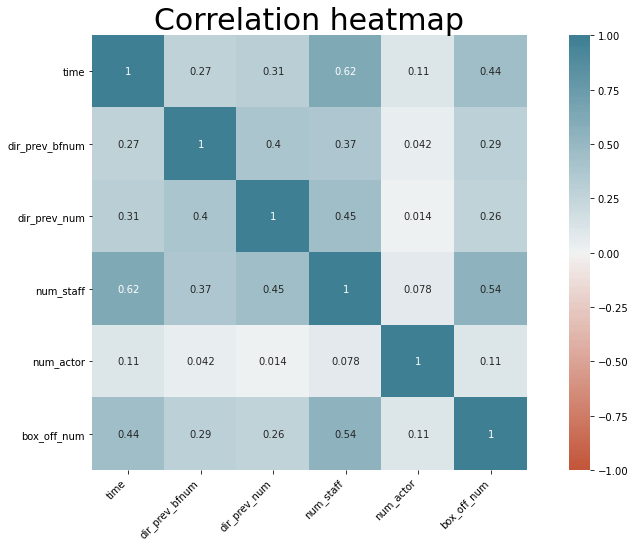

In [15]:
plt.colormap = plt.cm.PuBu
plt.figure(figsize=(15,8))
ax = sns.heatmap(
    corr, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True, annot = True
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    )

plt.title('Correlation heatmap', fontsize=30)
plt.show()

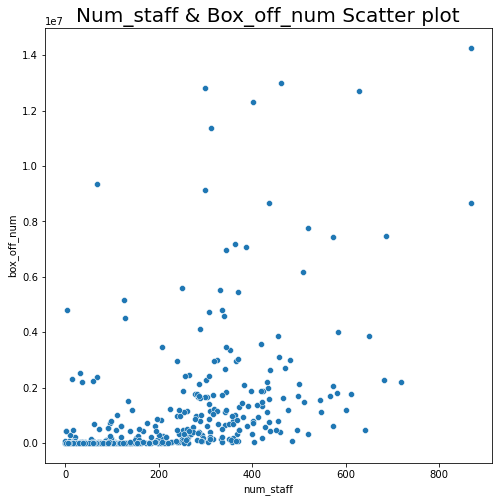

In [16]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=train, x='num_staff', y='box_off_num')
ax.set_title('Num_staff & Box_off_num Scatter plot', fontsize=20)
plt.show()

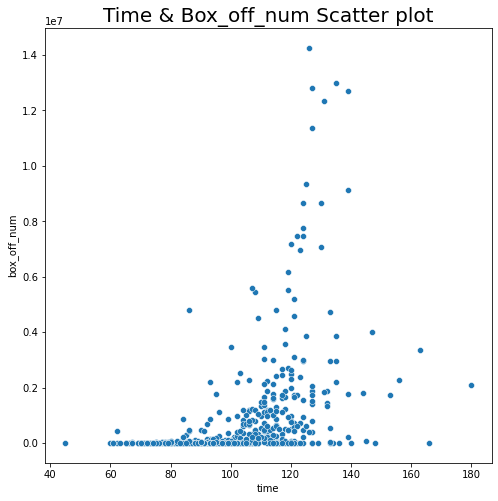

In [17]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data=train, x='time', y='box_off_num')
ax.set_title('Time & Box_off_num Scatter plot', fontsize=20)
plt.show()

여기까지 전처리 작업과 EDA를 해보았다.

### step3. 변수 선택 및 모델 구축(Feature Engineering & Initial Modeling)

#### **1. 첫 번째 모델**

In [18]:
# 모델 생성
model = LGBMRegressor(random_state = 777, n_estimators = 100)

# 데이터 분할
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

X_train, X_test, y_train = train[features], test[features], train[target]

# 모델 학습
model.fit(X_train, y_train)

LGBMRegressor(random_state=777)

In [19]:
# submission 데이터 셋 복사
singleLGBM = submission.copy()
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [20]:
# 예측 값을 singleLGBM에 대입
singleLGBM['box_off_num'] = model.predict(X_test)
singleLGBM.head()

,title,box_off_num
0,용서는 없다,3.760144e+06
1,아빠가 여자를 좋아해,7.579988e+05
2,하모니,-1.091700e+04
3,의형제,1.490854e+06
4,평행 이론,8.458000e+05


In [21]:
singleLGBM.to_csv('pydata/singleLGBM.csv', index = False)

많이 잘못 됬다는것을 볼 수 있다. 관객수가 음수값이 나올수가 없는데 음수가 나오는것을 확인할수있다. 이 모델은 성능이 별로 안좋은거 같다. 다른 모델로 넘어가보도록 하자.


#### **2. 두번째 모델(KFold 교차검증)**

In [22]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 777)

n_splits = 5은 몇 등분 할지 설정후 shuffle = True는 섞어서 5등분을 시킨다는 의미이다. 섞는 이유는 순서에 대한 영향력이 있을수 있기에 섞어준다고 생각하자.

In [23]:
for train_idx, val_idx in kfold.split(X_train):
    print(len(train_idx), len(val_idx))
    break

480 120


위 결과를 보면 5등분이 되었다는 것을 알 수 있다. train_idx은 600개중 4등분인 480개 val_idx는 120개로 나눠져있다.

In [24]:
model = LGBMRegressor(random_state=777, n_estimators=1000)

models = [] # 모델을 담을 바구니라 생각하자.

for train_idx, val_idx in kfold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

[100]	valid_0's l2: 2.70572e+12


C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


early_stopping_rounds=100은 100번의 과정동안 오차율이 감소되지 않으면 멈춰라라는 명령어이다. 그이상하면 과적합이 발생하기 때문에 설정해 준다고 생각하자.  
verbose = 100 은 우리가 1000번 학습을 하는데 100번째 모델마다 출력값을 산출해 달라라는 뜻이라 이해하자.

In [25]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [26]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [27]:
preds

[array([3367422.08211024,  961138.88337016, 1097929.67851313,
        2097270.81999921,  781476.31131047,  123133.23396977,
          84085.01896248,  199222.92670303,  124854.97973097,
        1072684.78820647,  657040.55769984, 1644701.47160779,
         924735.72080619,  191699.58415836,  723218.39948755,
        2395613.42888462,  113180.54906592, 1882765.92812296,
          97286.47282983,  417270.42113431,  161482.3367577 ,
          63495.73363115,  598057.42337284,  249411.25868881,
         308424.71884273, 1319518.60852241,  202273.52740684,
        1076683.13768137,  491636.41945325,  183406.6380314 ,
        1740233.45816734,   86696.17528125,  440430.29773088,
        2040944.13061099,  113375.45695331,  531746.29484356,
         106207.35971699,  169560.79581187,  158101.0895316 ,
          95037.29701059,  466355.50624629,  197548.63265325,
         198810.0901353 ,  682743.4340129 ,  679265.22397749,
         617812.91125278,  219182.85833837,   83712.10602149,
        

이렇게 예측값들이 5세트가 있는 것을 볼 수 있다.

In [28]:
 # 답안지 복사
kfoldLightGBM = submission.copy()

In [29]:
np.mean(preds, axis=0)

array([3367422.08211024,  961138.88337016, 1097929.67851313,
       2097270.81999921,  781476.31131047,  123133.23396977,
         84085.01896248,  199222.92670303,  124854.97973097,
       1072684.78820647,  657040.55769984, 1644701.47160779,
        924735.72080619,  191699.58415836,  723218.39948755,
       2395613.42888462,  113180.54906592, 1882765.92812296,
         97286.47282983,  417270.42113431,  161482.3367577 ,
         63495.73363115,  598057.42337284,  249411.25868881,
        308424.71884273, 1319518.60852241,  202273.52740684,
       1076683.13768137,  491636.41945325,  183406.6380314 ,
       1740233.45816734,   86696.17528125,  440430.29773088,
       2040944.13061099,  113375.45695331,  531746.29484356,
        106207.35971699,  169560.79581187,  158101.0895316 ,
         95037.29701059,  466355.50624629,  197548.63265325,
        198810.0901353 ,  682743.4340129 ,  679265.22397749,
        617812.91125278,  219182.85833837,   83712.10602149,
       1206257.86593038,

In [30]:
# mean 평균값함수, axis 축
kfoldLightGBM['box_off_num'] = np.mean(preds, axis=0)

In [31]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


In [32]:
kfoldLightGBM.to_csv('pydata/kfoldLightGBM.csv', index = False)

#### **3. 세번째 모델**

In [33]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

genre와dir_prev_bfnum를 포함해서 활용해보도록 하자. 문제는 genre 데이터는 글자로 되어있으니 숫자로 변환하여 사용해야한다.

In [34]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [35]:
# sklearn에서 제공하는 labelEncoder를 활용해서 문자열을 숫자로 변환

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int32

숫자로 변환되있는걸 확인 할 수 있다. test셋도 변환해주자.

In [36]:
test['genre'] = le.transform(test['genre'])
test['genre']

0       2
1       5
2       4
3      10
4       1
       ..
238     4
239     3
240     2
241     4
242     5
Name: genre, Length: 243, dtype: int32

test셋도 변환될걸 확인 할 수 있다.  
다음은 features에 전처리된 dir_prev_bfnum와 문자열을 숫자로 변환한 genre를 추가해주자.

In [38]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor','dir_prev_bfnum', 'genre']
X_train, X_test, y_train = train[features], test[features], train[target]

model = LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in kfold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.62067e+12
[100]	valid_0's l2: 4.39227e+12
[100]	valid_0's l2: 3.29841e+12
[100]	valid_0's l2: 1.56499e+12
[100]	valid_0's l2: 1.60118e+12


In [39]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum,genre
0,125,2,304,3,3.005290e+05,2
1,113,4,275,3,3.427002e+05,5
2,115,3,419,7,4.206611e+06,4
3,116,2,408,2,6.913420e+05,10
4,110,1,380,1,3.173800e+04,1


In [40]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [41]:
feLightGBM = submission.copy()
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)
feLightGBM.head()

,title,box_off_num
0,용서는 없다,3.395493e+06
1,아빠가 여자를 좋아해,8.235439e+05
2,하모니,1.162055e+06
3,의형제,2.184689e+06
4,평행 이론,8.093288e+05


In [42]:
feLightGBM.to_csv('pydata/feLightGBM.csv', index = False)

#### **4. 네번째 모델**

In [46]:
model = LGBMRegressor(random_state=777, n_estimators=1000)

param_grid = {'learning_rate': [.1, .001, .003],
             'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
                 param_grid=param_grid,
                  scoring= 'neg_mean_squared_error',
                  cv = kfold # 5라고 작성해도 됨
                 )
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.001, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

params에서 learning_rate는 모델링을 하는 간격으로, 값이 적을수록 점점 더 미세하게 모델의 변화가 이루어진다로 생각하면 된다.  
scoring을 rmse로 한 이후는 현재 이 대회의 평가지표가 rmse값이기 때문에 이렇게 설정했다.

In [47]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

gs.best_params_ 6개의 조합중 가장 좋았던 조합을 확인 할 수 있다. 위 가장 좋은 성능을 적용하여 모델링을 해주었다.

In [52]:
model = gs.best_estimator_
preds = model.predict(X_test)

In [54]:
gslgbm = submission.copy()
gslgbm['box_off_num'] = preds
gslgbm.head()

,title,box_off_num
0,용서는 없다,3.160220e+06
1,아빠가 여자를 좋아해,1.087365e+06
2,하모니,1.468196e+06
3,의형제,1.639070e+06
4,평행 이론,9.470239e+05


In [56]:
gslgbm.to_csv('pydata/gslgbm.csv', index=False)